## LDA Topic Modeling

**NOTE: The following is from an old version of the class and may not work anymore. I'm just keeping it here as example code**

Finally, I'm going to show an example of topic modeling.

This is complicated, both mathematically and in code. The `gensim` package has some smart defaults, and I'm showing here the most basic, simplest way to do LDA topic modelling. There is a good, slighlty more advanced [tutorial at the gensim site](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html).

The basic idea of topic modeling is that you are trying to optimize the likelihood of a set of distributions of words over topics and topics over documents based on the documents that actually exist. The idea is that each document can be seen as being generated by a mix of topics, and we try to find the set of topics that best matches. This works best on a large set of documents, which are themselves each quite large. In this case, the posts that we have are actually quite short. Let's plot the distribution of sizes and use topic modeling on the one with the longest posts.

In [ ]:
sr['logged_post_length'] = np.log1p(sr.all_text.str.len())

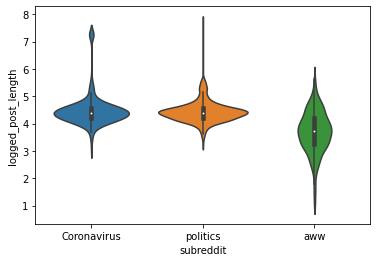

In [ ]:
sns.violinplot(data=sr, 
               y='logged_post_length',
               x='subreddit'
              );

They all look pretty similar, but r/Coronavirus is maybe a bit longer, so let's use that.

In [ ]:
# Again, we need to do an NLTK download
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jeremy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import gensim.parsing.preprocessing as gpp
from gensim.corpora import Dictionary
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.ldamodel import LdaModel
from pprint import pprint
from nltk.tokenize import RegexpTokenizer

def run_lda(docs, 
            n_topics, # How many topics to return
            min_count = 20 # How many docs a word must appear in to be included
           ):
    # Split the documents into tokens. This creates a list of words for each document.
    print(f"Preprocessing documents...")
    lemmatizer = WordNetLemmatizer()
    docs = [gpp.preprocess_string(x, filters=[gpp.strip_punctuation,
                                              gpp.strip_multiple_whitespaces,
                                              gpp.strip_numeric,
                                              gpp.remove_stopwords,
                                              gpp.strip_short
                                             ]) for x in docs]
    
    # Lemmatize the words

    dictionary = Dictionary(docs)
    for doc in docs:
        dictionary.add_documents([[lemmatizer.lemmatize(token) for token in doc]])
    dictionary.filter_extremes(no_below=min_count, no_above=0.5)

    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))
    
    
    # Train LDA model
    print("Running the model...")
    # Set training parameters.
    num_topics = n_topics
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    #temp = dictionary[0]  # This is only to "load" the dictionary.
    #id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )
    
    return (model, corpus, dictionary, docs)
    

## r/Coronavirus topics

This code tries to look at the range of topics from the Coronavirus subreddit. It takes all of the different posts from just the Coronavirus subreddit and treats each one as a document. The problem is that they are almost all short (they are typically headlines of articles that are shared).

Note that this may take a minute to run.

In [ ]:
dataset = sr.loc[sr.subreddit == 'Coronavirus', 'all_text']
model, corpus, dictionary, docs = run_lda(dataset, 5, min_count = 10)
pprint(model.print_topics())

Preprocessing documents...
Number of unique tokens: 227
Number of documents: 508
Running the model...
[(0,
  '0.065*"https" + 0.046*"www" + 0.046*"com" + 0.042*"Coronavirus" + '
  '0.032*"reddit" + 0.032*"wiki" + 0.026*"COVID" + 0.026*"tracker" + '
  '0.026*"information" + 0.020*"amp"'),
 (1,
  '0.201*"COVID" + 0.049*"cases" + 0.040*"vaccines" + 0.037*"new" + '
  '0.030*"says" + 0.029*"Covid" + 0.027*"Florida" + 0.027*"vaccinated" + '
  '0.022*"Moderna" + 0.019*"CDC"'),
 (2,
  '0.179*"vaccine" + 0.108*"COVID" + 0.058*"mandate" + 0.030*"Vaccines" + '
  '0.030*"workers" + 0.026*"study" + 0.025*"virus" + 0.022*"immunity" + '
  '0.022*"Nicki" + 0.019*"What"'),
 (3,
  '0.106*"Covid" + 0.041*"coronavirus" + 0.034*"says" + 0.034*"The" + '
  '0.032*"unvaccinated" + 0.030*"New" + 0.030*"pandemic" + 0.030*"health" + '
  '0.029*"Vaccine" + 0.027*"care"'),
 (4,
  '0.073*"Covid" + 0.072*"COVID" + 0.042*"Pfizer" + 0.038*"FDA" + '
  '0.032*"booster" + 0.030*"deaths" + 0.030*"Are" + 0.024*"shot" + '
 

### Going back to the original documents to understand the topics

The most common words in a topic are helpful but they can be misleading. In order to make sure that topics are capturing something meaningful, it's important to go back to the original documents. This code shows how to do that.

First, we get the topics for each document.

In [ ]:
doc_topics = model.get_document_topics(corpus)

doc_topics[0]

[(0, 0.017005496),
 (1, 0.88320833),
 (2, 0.026466075),
 (3, 0.040989295),
 (4, 0.032330766)]

This is basically a distribution of topics (by topic number) for each document. We have to do some work to connect this back to the documents themselves. First, let's put these into a dataframe.

In [ ]:
result = []
doc_id = 0
# Loop through the topic distributions for each document
for doc in doc_topics:
    # Create a temporary dictionary for this document
    curr_result = {}
    # For each topic, add an entry to the dictionary
    for topic_number, weight in doc:
        curr_result[f"topic_{topic_number}"] = weight
    # Then, add the dictionary to our list of dictionaries
    result.append(curr_result)
        
# Turn the list of dictionaries into a dataframe
doc_topic_df = pd.DataFrame(result)

Then, let's add the original documents to the dataframe. It took me a bit of wrangling to figure out how to get it in the right format.

In [ ]:
# This took some 
doc_topic_df['original_text'] = dataset.reset_index().all_text

Now, we can sort by each topic, and show the text associated.

In [ ]:
doc_topic_df.sort_values('topic_1', ascending=False).head(20)

,topic_0,topic_1,topic_2,topic_3,topic_4,original_text
389,NaN,0.951202,0.011050,0.017162,0.013486,Brazil at lowest 14-day moving average for new...
401,NaN,0.944822,0.012507,0.019373,0.015263,Tennessee reports highest number of new COVID-...
189,NaN,0.944789,0.012508,0.019388,0.015279,"Key data on U.S. J&amp;J, Moderna COVID-19 boo..."
382,NaN,0.944671,0.012507,0.019498,0.015287,"Moderna combines COVID, flu, RSV vaccines in s..."
305,NaN,0.944445,0.012508,0.019744,0.015266,21% of children hospitalized with COVID requir...
121,NaN,0.936423,0.014407,0.022327,0.017586,Texas couple asked to leave restaurant for wea...
114,NaN,0.936378,0.014407,0.022378,0.017580,DeSantis’ new Florida surgeon general question...
418,0.010915,0.925060,0.016990,0.026308,0.020728,A new nationwide study suggests that almost ha...
73,0.010915,0.925050,0.016987,0.026320,0.020728,Florida governor gives parents right to send i...
65,0.010915,0.925047,0.016987,0.026323,0.020728,Florida's new surgeon general Joseph Ladapo op...


In [ ]:
doc_topic_df.sort_values('topic_4', ascending=False).head(20)

Jupyter automatically truncates the text, but to see the full text, we can look at the document based on the index number (the far-left column in the dataframe). For example, this is document 269

In [ ]:
dataset[269]

### Visualizing results

There's a cool tool called LDAVis that previous students found, and that works well with gensim models. Here's how you run it.

In [ ]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
    
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model, corpus, dictionary)
pyLDAvis.display(vis)

## Finding the number of topics

One approach to choosing _k_, the number of topics, is topic coherence. Here is one example of how to calculate this for many values of k. You'd then find the max, and choose that number of topics.

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
coherence = []
for k in range(5,20):
    print(f'Running with {k} topics')
    model, corpus, dictionary, docs = run_lda(dataset, n_topics=k)
    coherence_model = CoherenceModel(model=model, 
                               texts=docs, 
                               dictionary=dictionary, 
                               coherence='c_v')
    coherence.append((coherence_model.get_coherence(), k))
print(coherence)

In [ ]:
sorted(coherence, reverse=True)